In [20]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time
from tqdm import tqdm
import random
from konlpy.tag import Okt
from konlpy.tag import Kkma

---
### 1. 주식 종목토론실 크롤링
---

In [ ]:
# 종목 코드 입력받으면 전체 종목토론실 내용 받아오기
import time
from tqdm import tqdm
import random
def newsgroup(code):
    # 100페이지 이후부터 제한 => referer이용
    dic={'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_5_2)','referer':'https://finance.naver.com/item/board.naver?code=005930&page=1'}
    url=requests.get(f'https://finance.naver.com/item/board.naver?code={code}',headers=dic)
    html=BeautifulSoup(url.text)
    end = int(html.find('td',class_='pgRR').find('a')['href'].split("=")[-1])

    box=[]
    
    for i in tqdm(range(1,end+1)):
        time.sleep(1+random.random())
        url=requests.get(f'https://finance.naver.com/item/board.naver?code={code}&page={i}',headers=dic)
        html=BeautifulSoup(url.text)
        table=html.find('table',class_='type2')

        # 제목 리스트 생성
        title_List=[]
        page_title=html.find_all('td', class_='title')
        for i in page_title:
            title_List.append(i.find('a')['title'])
            
        # 날짜 리스트 생성
        page_date=[]
        date_List=html.find_all('span',class_='tah p10 gray03')
        for i in date_List:
            if len(i.text)==16:
                page_date.append(i.text)

        box.append(pd.DataFrame(title_List,page_date,columns=['내용']))

        # box.append(pd.read_html(str(table))[0].dropna(how='all'))

    df=pd.concat(box)
    return df

In [ ]:
df=newsgroup("122870")
df

In [ ]:
# 오늘 종목토론실 내용 가져오기
import time
from tqdm import tqdm
import random
import requests
from bs4 import BeautifulSoup
import pandas as pd
def today_newsgroup(code):
    dic={'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_5_2)','referer':'https://finance.naver.com/item/board.naver?code=005930&page=1'}
    url=requests.get(f'https://finance.naver.com/item/board.naver?code={code}',headers=dic)
    html=BeautifulSoup(url.text)
    end = int(html.find('td',class_='pgRR').find('a')['href'].split("=")[-1])

    box=[]
    
    cnt=1
    flag=True

    while flag:

        time.sleep(1+random.random())
        url=requests.get(f'https://finance.naver.com/item/board.naver?code={code}&page={cnt}',headers=dic)
        html=BeautifulSoup(url.text)

        # 제목 리스트 생성
        title_List=[]
        page_title=html.find_all('td', class_='title')
        for i in page_title:
            title_List.append(i.find('a')['title'])
            
        # 날짜 리스트 생성
        page_date=[]
        date_List=html.find_all('span',class_='tah p10 gray03')
        for i in date_List:
            if len(i.text)==16:
                page_date.append(i.text)

        # 최초 날짜 리스트 생성
        today_date=html.find_all('span',class_='tah p10 gray03')
        today_date
        f_date=today_date[0].text[8:10]

        # 오늘 토론실 내용 가져오기        
        max_cnt=0
        for i in page_date:
            if f_date==i[8:10]:
                max_cnt+=1
            elif f_date!=i[8:10]:
                flag=False

        mini_df=pd.DataFrame(title_List,page_date,columns=['내용'])
        box.append(mini_df.iloc[:max_cnt])
        print(len(box))
        cnt+=1
    df=pd.concat(box)
    return df

In [ ]:
today_df=today_newsgroup("122870")
today_df

---
### 2. 뉴스, 토론실, 주가 데이터 불러오기
---

In [73]:
news_DF=pd.read_csv('./edu/11.text/teamproject/data/newsArticle_YG.csv')
debate_DF=pd.read_csv('./edu/11.text/teamproject/data/debate.csv')
stock_DF=pd.read_csv('./edu/11.text/teamproject/data/yg_stock.csv')

In [65]:
news_DF['날짜']=pd.to_datetime(news_DF['날짜'])
news_DF['정리']=news_DF['제목']+" "+news_DF['내용']

---
### 3. 감성점수 생성
---

In [29]:
okt=Okt()
kkma=Kkma()

In [30]:
def mal(df):
    total=[]
    for i in tqdm(df['정리']):
        t=okt.normalize(i)
        t=kkma.pos(t)
        box=[]
        for j in t:
            if j[1][:2]=='NN':
                box.append(j[0])
            elif j[1] in ['VV','VA']:
                box.append(j[0]+'다')
        total.append(" ".join(box))
    df['정리'] = total
    return df

In [32]:
def gamsung(df):
    total=[]
    total_score=[]
    okt = Okt()
    # 감성사전
    senti=pd.read_csv('./edu/11.text/data/knu_sentiment_lexicon.csv')

    for i in tqdm(df['정리']):
        t=okt.normalize(i)
        score = 0
        for w,p in zip(senti['word'],senti['polarity']):
            score += t.count(w)*p
        total_score.append(score)
    df['감성점수']=total_score
    return df

In [66]:
news_mal=mal(news_DF)
news_mal

  1%|          | 170/22314 [00:09<19:36, 18.82it/s]

In [67]:
news_gamsung=gamsung(news_mal)

  0%|          | 0/22314 [00:00<?, ?it/s]

100%|██████████| 22314/22314 [02:40<00:00, 139.25it/s]


In [68]:
# 일별 뉴스 감성점수 평균 계산
news_gamsung_score=news_gamsung.groupby('날짜').mean('news_감성점수')

In [81]:
news_gamsung_score=news_gamsung_score.drop(axis=1,columns='Unnamed: 0')

In [82]:
news_gamsung_score

,감성점수
날짜,
2017-06-01,0.6
2017-06-02,-2.4
2017-06-03,0.7
2017-06-04,-1.3
2017-06-05,-0.8
...,...
2023-09-30,0.2
2023-10-01,-1.4
2023-10-02,-2.2


In [34]:
stock_DF

,날짜,종가,전일비,시가,고가,저가,거래량
0,2023.10.04,60000.0,2800.0,61500.0,61900.0,59300.0,618460.0
1,2023.09.27,62800.0,1800.0,63600.0,64200.0,62500.0,511829.0
2,2023.09.26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0
3,2023.09.25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0
4,2023.09.22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0
...,...,...,...,...,...,...,...
2917,2011.11.29,78500.0,0.0,79900.0,81900.0,77000.0,396516.0
2918,2011.11.28,78500.0,1100.0,81500.0,82800.0,76800.0,543186.0
2919,2011.11.25,79600.0,10300.0,92000.0,97200.0,77300.0,1429458.0
2920,2011.11.24,89900.0,11700.0,81500.0,89900.0,81500.0,1575530.0


In [74]:
stock_DF['날짜']=pd.to_datetime(stock_DF['날짜'])

In [75]:
stock_DF['날짜']

0      2023-10-04
1      2023-09-27
2      2023-09-26
3      2023-09-25
4      2023-09-22
          ...    
2917   2011-11-29
2918   2011-11-28
2919   2011-11-25
2920   2011-11-24
2921   2011-11-23
Name: 날짜, Length: 2922, dtype: datetime64[ns]

In [76]:
from datetime import datetime
date = datetime.strptime('2017-06-07', "%Y-%m-%d")
stock_all=stock_DF[stock_DF['날짜']>=date]
stock_all=stock_all.sort_values('날짜').reset_index(drop=True)

In [55]:
debate_DF=pd.read_csv('./edu/11.text/teamproject/data/debate.csv')
debate_DF['날짜']=debate_DF['날짜'].str[0:10]
debate_DF['날짜']=pd.to_datetime(debate_DF['날짜'])
debate_DF.rename(columns={'내용':'정리'},inplace=True)



In [56]:
debate_mal=mal(debate_DF)
debate_mal

100%|██████████| 113860/113860 [08:44<00:00, 217.10it/s]


,날짜,정리
0,2023-10-04,주식 보유 사람 없다 거 생각
1,2023-10-04,와이 지가 중국 넘어가다 가능성 있다
2,2023-10-04,김 지수 씨 파리 호텔 어다 요리 먹다 사진 올리다
3,2023-10-04,새끼 뇌 없다
4,2023-10-04,오다 주주 판단 미스
...,...,...
113855,2017-06-07,네이버 지 투자 돈 있다
113856,2017-06-07,원 대 들어가다 안전벨트 매다
113857,2017-06-07,참 어럽다 종목 지치다 지치다
113858,2017-06-07,생각 버티다 와이지 힘 쎄다


In [57]:
debate_gamsung=gamsung(debate_mal)
debate_gamsung_score=debate_gamsung.groupby('날짜').mean('감성점수')
debate_gamsung_score

100%|██████████| 113860/113860 [08:02<00:00, 236.06it/s]


,감성점수
날짜,
2017-06-07,-0.382716
2017-06-08,-0.200000
2017-06-09,0.047619
2017-06-10,-0.083333
2017-06-11,0.000000
...,...
2023-09-30,0.166667
2023-10-01,-0.156863
2023-10-02,-0.203125


In [58]:
min(debate_gamsung_score.index)
debate_stock_DF = stock_DF[stock_DF['날짜']>=min(debate_gamsung_score.index)]
stock_debate_all=debate_stock_DF.merge(debate_gamsung_score,on='날짜')
stock_debate_all

,날짜,종가,전일비,시가,고가,저가,거래량,감성점수
0,2023-10-04,60000.0,2800.0,61500.0,61900.0,59300.0,618460.0,-0.177686
1,2023-09-27,62800.0,1800.0,63600.0,64200.0,62500.0,511829.0,-0.206687
2,2023-09-26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0,-0.256055
3,2023-09-25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0,-0.294326
4,2023-09-22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0,-0.248634
...,...,...,...,...,...,...,...,...
1552,2017-06-13,32200.0,350.0,32200.0,32550.0,31700.0,188492.0,-0.116279
1553,2017-06-12,32550.0,950.0,33300.0,33500.0,32200.0,171118.0,0.218750
1554,2017-06-09,33500.0,350.0,33700.0,33750.0,33050.0,143263.0,0.047619
1555,2017-06-08,33150.0,550.0,32300.0,33400.0,32300.0,150577.0,-0.200000


In [83]:
stock_all=stock_all.merge(debate_gamsung_score,on='날짜')

In [84]:
stock_all=stock_all.rename(columns={'감성점수':'deb_감성점수'})

In [85]:
stock_all

,날짜,종가,전일비,시가,고가,저가,거래량,deb_감성점수
0,2017-06-07,32600.0,850.0,33000.0,33100.0,32500.0,219408.0,-0.382716
1,2017-06-08,33150.0,550.0,32300.0,33400.0,32300.0,150577.0,-0.200000
2,2017-06-09,33500.0,350.0,33700.0,33750.0,33050.0,143263.0,0.047619
3,2017-06-12,32550.0,950.0,33300.0,33500.0,32200.0,171118.0,0.218750
4,2017-06-13,32200.0,350.0,32200.0,32550.0,31700.0,188492.0,-0.116279
...,...,...,...,...,...,...,...,...
1552,2023-09-22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0,-0.248634
1553,2023-09-25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0,-0.294326
1554,2023-09-26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0,-0.256055
1555,2023-09-27,62800.0,1800.0,63600.0,64200.0,62500.0,511829.0,-0.206687


In [86]:
news_gamsung_score

,감성점수
날짜,
2017-06-01,0.6
2017-06-02,-2.4
2017-06-03,0.7
2017-06-04,-1.3
2017-06-05,-0.8
...,...
2023-09-30,0.2
2023-10-01,-1.4
2023-10-02,-2.2


In [87]:
stock_all=stock_all.merge(news_gamsung_score,on='날짜')

In [101]:
stock_all=stock_all.rename(columns={'감성점수':'news_감성점수'})

In [90]:
stock_all

,날짜,종가,전일비,시가,고가,저가,거래량,deb_감성점수,감성점수
0,2017-06-07,32600.0,850.0,33000.0,33100.0,32500.0,219408.0,-0.382716,-3.2
1,2017-06-08,33150.0,550.0,32300.0,33400.0,32300.0,150577.0,-0.200000,-2.5
2,2017-06-09,33500.0,350.0,33700.0,33750.0,33050.0,143263.0,0.047619,-5.3
3,2017-06-12,32550.0,950.0,33300.0,33500.0,32200.0,171118.0,0.218750,0.3
4,2017-06-13,32200.0,350.0,32200.0,32550.0,31700.0,188492.0,-0.116279,0.3
...,...,...,...,...,...,...,...,...,...
1552,2023-09-22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0,-0.248634,0.9
1553,2023-09-25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0,-0.294326,0.1
1554,2023-09-26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0,-0.256055,-0.7
1555,2023-09-27,62800.0,1800.0,63600.0,64200.0,62500.0,511829.0,-0.206687,-2.1


In [95]:
ud=[]
for i in range(0,len(stock_all)):
    if i!=0:
        ud.append((stock_all.iloc[i]['종가']-stock_all.iloc[i-1]['종가'])/stock_all.iloc[i]['종가']*100)
    else:
        ud.append(0)
stock_all['등락']=ud
stock_all['증감(2%)']=[1 if i>=2 else 0 for i in stock_all['등락']]
stock_all

,날짜,종가,전일비,시가,고가,저가,거래량,deb_감성점수,감성점수,등락,증감(2%)
0,2017-06-07,32600.0,850.0,33000.0,33100.0,32500.0,219408.0,-0.382716,-3.2,0.000000,0
1,2017-06-08,33150.0,550.0,32300.0,33400.0,32300.0,150577.0,-0.200000,-2.5,1.659125,0
2,2017-06-09,33500.0,350.0,33700.0,33750.0,33050.0,143263.0,0.047619,-5.3,1.044776,0
3,2017-06-12,32550.0,950.0,33300.0,33500.0,32200.0,171118.0,0.218750,0.3,-2.918587,0
4,2017-06-13,32200.0,350.0,32200.0,32550.0,31700.0,188492.0,-0.116279,0.3,-1.086957,0
...,...,...,...,...,...,...,...,...,...,...,...
1552,2023-09-22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0,-0.248634,0.9,-4.216867,0
1553,2023-09-25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0,-0.294326,0.1,-1.374046,0
1554,2023-09-26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0,-0.256055,-0.7,-1.393189,0
1555,2023-09-27,62800.0,1800.0,63600.0,64200.0,62500.0,511829.0,-0.206687,-2.1,-2.866242,0


In [102]:
stock_all

,날짜,종가,전일비,시가,고가,저가,거래량,deb_감성점수,news_감성점수,등락,증감(2%)
0,2017-06-07,32600.0,850.0,33000.0,33100.0,32500.0,219408.0,-0.382716,-3.2,0.000000,0
1,2017-06-08,33150.0,550.0,32300.0,33400.0,32300.0,150577.0,-0.200000,-2.5,1.659125,0
2,2017-06-09,33500.0,350.0,33700.0,33750.0,33050.0,143263.0,0.047619,-5.3,1.044776,0
3,2017-06-12,32550.0,950.0,33300.0,33500.0,32200.0,171118.0,0.218750,0.3,-2.918587,0
4,2017-06-13,32200.0,350.0,32200.0,32550.0,31700.0,188492.0,-0.116279,0.3,-1.086957,0
...,...,...,...,...,...,...,...,...,...,...,...
1552,2023-09-22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0,-0.248634,0.9,-4.216867,0
1553,2023-09-25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0,-0.294326,0.1,-1.374046,0
1554,2023-09-26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0,-0.256055,-0.7,-1.393189,0
1555,2023-09-27,62800.0,1800.0,63600.0,64200.0,62500.0,511829.0,-0.206687,-2.1,-2.866242,0


In [98]:
stock_all['증감(2%)'].value_counts()

증감(2%)
0    1219
1     338
Name: count, dtype: int64

---
### 4. 데이터 분할
---

In [103]:
from sklearn.model_selection import train_test_split

In [213]:
target=stock_all['종가'].iloc[:-1]
feature=stock_all[['종가', '시가', '고가', '저가', '거래량','deb_감성점수', 'news_감성점수']].iloc[1:]

In [214]:
train_x,test_x,train_y,test_y=train_test_split(feature,target,test_size=0.2,shuffle=False)

---
### 5. 회귀모델 생성
---

In [107]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


In [108]:
knn=KNeighborsRegressor()
knn.fit(train_x,train_y)

KNeighborsRegressor()

In [215]:
rf=RandomForestRegressor()
rf.fit(train_x,train_y)
rf.score(train_x,train_y)
rf.score(test_x,test_y)
print(f"train_score : {rf.score(train_x,train_y)}\ntest_score : {rf.score(test_x,test_y)}")
result=rf.predict(stock_all[['종가', '시가', '고가', '저가', '거래량','deb_감성점수', 'news_감성점수']].iloc[-1].to_frame().T)[0]
print(f'예측 종가(감정분석X) : {result:.0f}원')

train_score : 0.9997577454272264
test_score : 0.8656985813248931
예측 종가(감정분석X) : 61988원


In [139]:
result=rf.predict(stock_all[['종가', '시가', '고가', '저가', '거래량','deb_감성점수', 'news_감성점수']].iloc[-1].to_frame().T)[0]

62094.0

In [141]:
year,month,day=datetime.today().year,datetime.today().month,datetime.today().day

In [ ]:
print(f'{year}년 {month}월 {day}일 예측 가격은 ')

In [137]:
stock_all[['종가', '시가', '고가', '저가', '거래량','deb_감성점수', 'news_감성점수']].iloc[-1].to_frame().T

종가            60000.000000
시가            61500.000000
고가            61900.000000
저가            59300.000000
거래량          618460.000000
deb_감성점수         -0.177686
news_감성점수        -0.400000
Name: 1556, dtype: float64

In [216]:
target=stock_all['증감(2%)'].iloc[:-1]
feature=stock_all[['종가', '시가', '고가', '저가', '거래량','deb_감성점수', 'news_감성점수']].iloc[1:]
train_x,test_x,train_y,test_y=train_test_split(feature,target,test_size=0.2)

---
### 6. 분류모델 생성
---

In [217]:
from sklearn.ensemble import RandomForestClassifier

In [220]:
rf2=RandomForestClassifier()
rf2.fit(train_x,train_y)
rf2.score(train_x,train_y)
rf2.score(test_x,test_y)
result=rf2.predict(stock_all[['종가', '시가', '고가', '저가', '거래량','deb_감성점수', 'news_감성점수']].iloc[-1].to_frame().T)

In [221]:
print(f"train_score : {rf2.score(train_x,train_y)}\ntest_score : {rf2.score(test_x,test_y)}")
if result==0:
    print('예측 결과 : 하락')
else:
    print('예측 결과 : 상승')

train_score : 1.0
test_score : 0.7916666666666666
예측 결과 : 상승


In [225]:
pred=rf2.predict(test_x)

In [226]:
from sklearn.metrics import classification_report
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       246
           1       0.54      0.11      0.18        66

    accuracy                           0.79       312
   macro avg       0.67      0.54      0.53       312
weighted avg       0.75      0.79      0.73       312



In [146]:
result

0

In [131]:
stock_debate_all=stock_debate_all.set_index('날짜')

In [ ]:
train=stock_debate_all[stock_debate_all.index.year <= 2021]
train.sort_index(inplace=True)
train

,종가,전일비,시가,고가,저가,거래량,감성점수,등락,증감
날짜,,,,,,,,,
2017-06-07,32600.0,850.0,33000.0,33100.0,32500.0,219408.0,-0.382716,0.0,0
2017-06-08,33150.0,550.0,32300.0,33400.0,32300.0,150577.0,-0.200000,550.0,1
2017-06-09,33500.0,350.0,33700.0,33750.0,33050.0,143263.0,0.047619,350.0,1
2017-06-12,32550.0,950.0,33300.0,33500.0,32200.0,171118.0,0.218750,-950.0,0
2017-06-13,32200.0,350.0,32200.0,32550.0,31700.0,188492.0,-0.116279,-350.0,0
...,...,...,...,...,...,...,...,...,...
2021-12-24,53400.0,100.0,53800.0,54200.0,53200.0,147199.0,0.090909,-100.0,0
2021-12-27,54500.0,1100.0,53500.0,54700.0,52800.0,237240.0,-0.388889,1100.0,1
2021-12-28,57100.0,2600.0,55000.0,57100.0,54500.0,494558.0,-0.600000,2600.0,1


In [ ]:
train_input=train.iloc[:-1].to_numpy()
train_target=train.iloc[1:,0].to_numpy()

In [ ]:
train_target

array([33150., 33500., 32550., ..., 57100., 55800., 55700.])

In [ ]:
test=stock_debate_all[stock_debate_all.index.year > 2021]
test.sort_index(inplace=True)
test

,종가,전일비,시가,고가,저가,거래량,감성점수,등락,증감
날짜,,,,,,,,,
2022-01-03,56300.0,600.0,56200.0,56800.0,55700.0,169816.0,-0.230769,600.0,1
2022-01-04,54800.0,1500.0,56800.0,56800.0,54200.0,317909.0,-0.173913,-1500.0,0
2022-01-05,53600.0,1200.0,55000.0,55100.0,53000.0,327415.0,-0.260870,-1200.0,0
2022-01-06,51600.0,2000.0,52600.0,53600.0,51000.0,412762.0,-0.142857,-2000.0,0
2022-01-07,51800.0,200.0,52000.0,52800.0,51400.0,213315.0,-0.424242,200.0,1
...,...,...,...,...,...,...,...,...,...
2023-09-22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0,-0.248634,-2800.0,0
2023-09-25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0,-0.294326,-900.0,0
2023-09-26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0,-0.256055,-900.0,0


In [ ]:
test_input=test.iloc[:-1].to_numpy()
test_target=test.iloc[1:,0].to_numpy()

---
### 7. 시각화
---

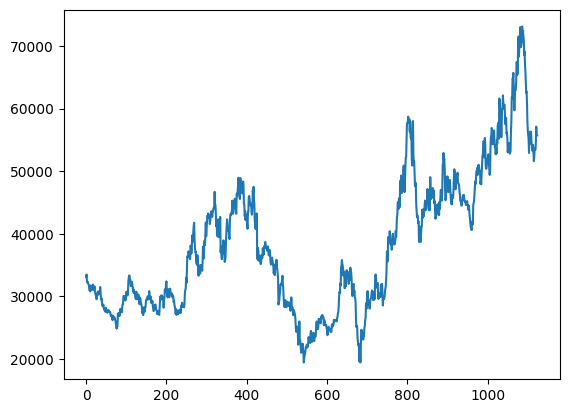

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_target)

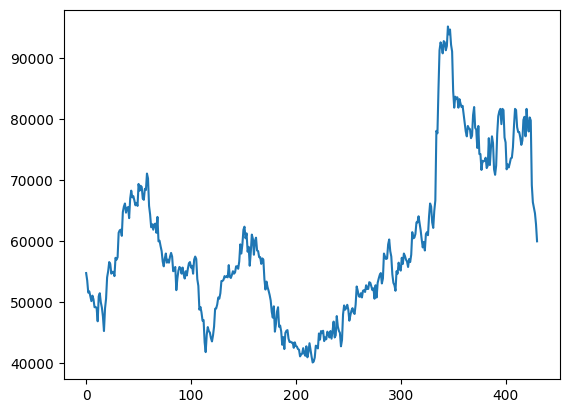

In [ ]:
plt.plot(test_target)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.fit(train_input,train_target)
rf.score(test_input,test_target)

0.8083851190960898

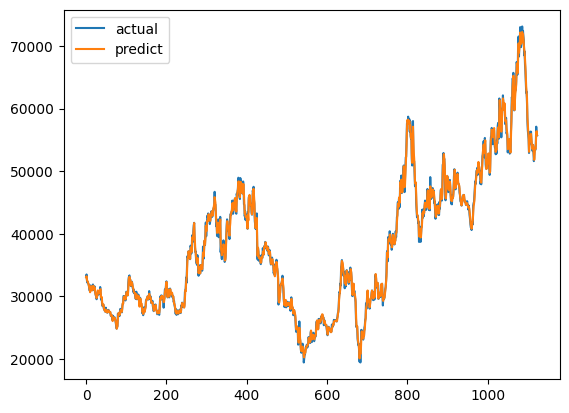

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_target)
plt.plot(rf.predict(train_input))
plt.legend(['actual','predict'])
plt.show()

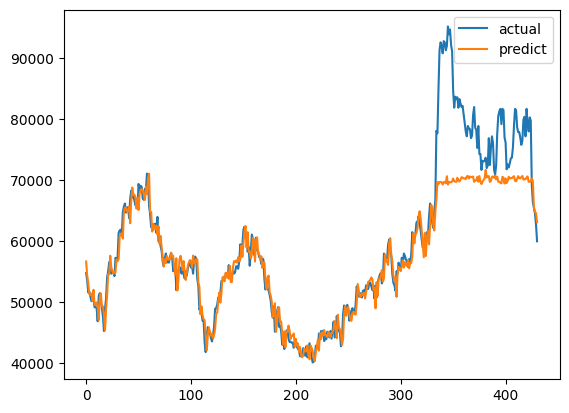

In [ ]:
plt.plot(test_target)
plt.plot(rf.predict(test_input))
plt.legend(['actual','predict'])
plt.show()

In [ ]:
train_input=train.iloc[:-1].to_numpy()
train_target=train.iloc[1:,8].to_numpy()

In [ ]:
test=stock_debate_all[stock_debate_all.index.year > 2021]
test.sort_index(inplace=True)
test

,종가,전일비,시가,고가,저가,거래량,감성점수,등락,증감
날짜,,,,,,,,,
2022-01-03,56300.0,600.0,56200.0,56800.0,55700.0,169816.0,-0.230769,600.0,1
2022-01-04,54800.0,1500.0,56800.0,56800.0,54200.0,317909.0,-0.173913,-1500.0,0
2022-01-05,53600.0,1200.0,55000.0,55100.0,53000.0,327415.0,-0.260870,-1200.0,0
2022-01-06,51600.0,2000.0,52600.0,53600.0,51000.0,412762.0,-0.142857,-2000.0,0
2022-01-07,51800.0,200.0,52000.0,52800.0,51400.0,213315.0,-0.424242,200.0,1
...,...,...,...,...,...,...,...,...,...
2023-09-22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0,-0.248634,-2800.0,0
2023-09-25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0,-0.294326,-900.0,0
2023-09-26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0,-0.256055,-900.0,0


In [ ]:
test_input=test.iloc[:-1].to_numpy()
test_target=test.iloc[1:,8].to_numpy()

In [ ]:
test_input

array([[ 5.63000000e+04,  6.00000000e+02,  5.62000000e+04, ...,
        -2.30769231e-01,  6.00000000e+02,  1.00000000e+00],
       [ 5.48000000e+04,  1.50000000e+03,  5.68000000e+04, ...,
        -1.73913043e-01, -1.50000000e+03,  0.00000000e+00],
       [ 5.36000000e+04,  1.20000000e+03,  5.50000000e+04, ...,
        -2.60869565e-01, -1.20000000e+03,  0.00000000e+00],
       ...,
       [ 6.55000000e+04,  9.00000000e+02,  6.43000000e+04, ...,
        -2.94326241e-01, -9.00000000e+02,  0.00000000e+00],
       [ 6.46000000e+04,  9.00000000e+02,  6.52000000e+04, ...,
        -2.56055363e-01, -9.00000000e+02,  0.00000000e+00],
       [ 6.28000000e+04,  1.80000000e+03,  6.36000000e+04, ...,
        -2.06686930e-01, -1.80000000e+03,  0.00000000e+00]])

In [ ]:
test_target

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(train_input,train_target)
rf.score(test_input,test_target)

0.5568445475638051

In [237]:
target=stock_all['종가'].iloc[:-1]
feature=stock_all[['종가', '시가', '고가', '저가', '거래량']].iloc[1:]

In [238]:
train_x,test_x,train_y,test_y=train_test_split(feature,target,test_size=0.2)

In [209]:
rf3=RandomForestRegressor()
rf3.fit(train_x,train_y)
rf3.score(train_x,train_y),rf3.score(test_x,test_y)
print(f"train_score : {rf3.score(train_x,train_y)}\ntest_score : {rf3.score(test_x,test_y)}")
result=rf3.predict(stock_all[['종가', '시가', '고가', '저가', '거래량']].iloc[-1].to_frame().T)[0]
print(f'예측 종가(감정분석X) : {result:.0f}원')

train_score : 0.9997594531218134
test_score : 0.9987713817964805
예측 종가(감정분석X) : 62356원


In [168]:
stock_all[['종가', '시가', '고가', '저가', '거래량']].iloc[-1].to_frame().T

,종가,시가,고가,저가,거래량
1556,60000.0,61500.0,61900.0,59300.0,618460.0


In [227]:
target=stock_all['증감(2%)'].iloc[:-1]
feature=stock_all[['종가', '시가', '고가', '저가', '거래량']].iloc[1:]

In [228]:
train_x,test_x,train_y,test_y=train_test_split(feature,target,test_size=0.2,stratify=target)

In [229]:
rf4=RandomForestClassifier()
rf4.fit(train_x,train_y)
rf4.score(train_x,train_y),rf4.score(test_x,test_y)

(1.0, 0.7660256410256411)

In [230]:
stock_all[['종가', '시가', '고가', '저가', '거래량']].iloc[-1].to_frame().T

,종가,시가,고가,저가,거래량
1556,60000.0,61500.0,61900.0,59300.0,618460.0


In [233]:
print(f"train_score : {rf4.score(train_x,train_y)}\ntest_score : {rf4.score(test_x,test_y)}")
result=rf4.predict(stock_all[['종가', '시가', '고가', '저가', '거래량']].iloc[-1].to_frame().T)[0]
result
if result==0:
    print('예측 결과 : 하락')
else:
    print('예측 결과 : 상승')

train_score : 1.0
test_score : 0.7660256410256411
예측 결과 : 하락


In [234]:
pred=rf4.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       244
           1       0.35      0.09      0.14        68

    accuracy                           0.77       312
   macro avg       0.57      0.52      0.50       312
weighted avg       0.69      0.77      0.71       312



In [235]:
stock_all.rename()

,날짜,종가,전일비,시가,고가,저가,거래량,deb_감성점수,news_감성점수,등락,증감(2%)
0,2017-06-07,32600.0,850.0,33000.0,33100.0,32500.0,219408.0,-0.382716,-3.2,0.000000,0
1,2017-06-08,33150.0,550.0,32300.0,33400.0,32300.0,150577.0,-0.200000,-2.5,1.659125,0
2,2017-06-09,33500.0,350.0,33700.0,33750.0,33050.0,143263.0,0.047619,-5.3,1.044776,0
3,2017-06-12,32550.0,950.0,33300.0,33500.0,32200.0,171118.0,0.218750,0.3,-2.918587,0
4,2017-06-13,32200.0,350.0,32200.0,32550.0,31700.0,188492.0,-0.116279,0.3,-1.086957,0
...,...,...,...,...,...,...,...,...,...,...,...
1552,2023-09-22,66400.0,2800.0,68000.0,68500.0,64300.0,1150903.0,-0.248634,0.9,-4.216867,0
1553,2023-09-25,65500.0,900.0,64300.0,68800.0,63400.0,1006574.0,-0.294326,0.1,-1.374046,0
1554,2023-09-26,64600.0,900.0,65200.0,66700.0,64200.0,368240.0,-0.256055,-0.7,-1.393189,0
1555,2023-09-27,62800.0,1800.0,63600.0,64200.0,62500.0,511829.0,-0.206687,-2.1,-2.866242,0
